### Creating a Working Restaurant Dataset 

Main goal: Create a recommender that will process Natural Language requests to eat a food in an area, and suggest the best place for the item.   

Goal: 
There are 4 different original datasets that include different pieces of information about various restaurants.  
This notebook creates a clean dataset of NY restaurants that has most information possible in a consistent format, focusing on key information points that will be used later: 
- Restaurant Name 
- Food Info 
- Price Category
- Avg Review Score
- Location Info (full address & zip code) - address format will be 55 Name Street, Borough, Zip Code
- Inspection Info ("recent" inspection and inspection results)

Some notes:   
1. Since this data is sourced from various sources that don't necessarily cross over in terms of collection time, it is a dummy dataset.
2. For inspection info, the cutoff year of the health inspection data - 2017 - should be the most relevant year to look at.    
3. Since this dataset is based on several sources with no common key, the best identifier that can be used here is the name of the restaurant combined with its zip code. As a result, differentiating branches is possible only in terms of location, but not other characteristics (e.g. if the Midtown location is higher rated than the Brooklyn one); differentiating between the same restaurant under two different names is impossible (e.g. "John's Chicken" located on Broadway and "John's Chicken - Broadway" would be considered two different restaurants).

 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import seaborn as sns
from nltk import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [2]:
ta_data = pd.read_csv("../../data/trip advisor restaurents  10k - trip_rest_neywork_1.csv")
gm_data = pd.read_csv("../../data/google_maps_restaurants(cleaned).csv")
menu_data = pd.read_csv("../../data/menu_data.csv")
menu_rest_data = pd.read_csv("../../data/restaurant_data.csv")
inspection_data = pd.read_csv("../../data/DOHMH_New_York_City_Restaurant_Inspection_Results.csv")

### Google Maps Data
this dataset includes data of NY&NJ restaurants: Name, Rating, Price Category, Location and other columns. 

**goal:** remove NJ restaurants, since the focus will be on NY places.

In [3]:
gm_data

,URL,Name,Rating,Rating Count,Detailed Ratings,Price Category,Address,Lat,Lon,ZipCode
0,https://www.google.com/maps/place/The+Firehous...,The Firehouse Family Restaurant & Bar,4.6,549.0,"{'Rating 5 ': 399.0, 'Rating 4 ': 105.0, 'Rati...",1.0,"42 Plauderville Ave, Garfield, NJ 07026",40.885012,-74.109239,7026
1,https://www.google.com/maps/place/H+Restaurant...,H Restaurant & SS Restaurant,NaN,NaN,{},NaN,"510 S River St, Hackensack, NJ 07601",40.863515,-74.035681,7601
2,https://www.google.com/maps/place/Joe%27s+Rest...,Joe's Restaurant,4.6,812.0,"{'Rating 5 ': 651.0, 'Rating 4 ': 99.0, 'Ratin...",2.0,"6611 Forest Ave, Ridgewood, NY 11385",40.707437,-73.903231,11385
3,https://www.google.com/maps/place/Mompou+Tapas...,Mompou Tapas Bar & Restaurant,4.4,1136.0,"{'Rating 5 ': 699.0, 'Rating 4 ': 287.0, 'Rati...",2.0,"77 Ferry St, Newark, NJ 07105",40.731355,-74.162045,7105
4,https://www.google.com/maps/place/Rasoi/data=!...,Rasoi,3.9,1904.0,"{'Rating 5 ': 845.0, 'Rating 4 ': 542.0, 'Rati...",2.0,"810 Newark Ave, Jersey City, NJ 07306",40.735757,-74.065378,7306
...,...,...,...,...,...,...,...,...,...,...
665,https://www.google.com/maps/place/4+Caminos+Me...,4 Caminos Mexican Restaurant,4.1,184.0,"{'Rating 5 ': 117.0, 'Rating 4 ': 25.0, 'Ratin...",2.0,"67-22 Fresh Pond Rd, Queens, NY 11385",40.705204,-73.896596,11385
666,https://www.google.com/maps/place/Pakshala+Res...,Pakshala Restaurant & Grill,5.0,151.0,"{'Rating 5 ': 148.0, 'Rating 4 ': 1.0, 'Rating...",2.0,"8120 Broadway, Queens, NY 11373",40.742983,-73.883445,11373
667,https://www.google.com/maps/place/Family+Meal+...,Family Meal at Blue Hill,4.6,1143.0,"{'Rating 5 ': 900.0, 'Rating 4 ': 148.0, 'Rati...",4.0,"75 Washington Pl, New York, NY 10011",40.732047,-73.999668,10011
668,https://www.google.com/maps/place/La+Posada+Ta...,La Posada Taqueria & Restaurant,4.0,444.0,"{'Rating 5 ': 255.0, 'Rating 4 ': 73.0, 'Ratin...",2.0,"334 Monroe St, Passaic, NJ 07055",40.864269,-74.128672,7055


In [4]:
# Checking what US states exist in the dataset
gm_data["State"] = gm_data["Address"].str.split(", ").apply(lambda l: l[-1]).str.split().apply(lambda l: l[0])
gm_data["State"].drop_duplicates()

0    NJ
2    NY
Name: State, dtype: object

In [5]:
# leaving only NY restaurants
gm_data = gm_data.dropna(axis=0, how="any")
gm_data = gm_data[gm_data["State"] == "NY"]

In [6]:
# leaving only relevant columns; changing address format to the standardized one 
gm_data = gm_data[["Name", "Rating", "Price Category", "Address", "ZipCode"]]
gm_data["ZipCode"] = gm_data["ZipCode"].astype(str)
gm_data["Address"] = gm_data.apply(lambda row: row["Address"].split(", ")[:2] + [str(row["ZipCode"])], axis=1).apply(lambda l: ", ".join(l))

In [7]:
gm_data

,Name,Rating,Price Category,Address,ZipCode
2,Joe's Restaurant,4.6,2.0,"6611 Forest Ave, Ridgewood, 11385",11385
6,Mexican Cantina Restaurant & Bar,4.5,2.0,"1736 Victory Blvd, Staten Island, 10314",10314
8,Golden Krust Caribbean Restaurant,3.7,1.0,"1014a Nostrand Ave, Brooklyn, 11225",11225
12,POLONICA RESTAURANT,4.5,2.0,"8303 3rd Ave, Brooklyn, 11209",11209
13,Serafina Italian Restaurant Tribeca,4.3,2.0,"95 W Broadway, New York, 10007",10007
...,...,...,...,...,...
661,Le Coucou,4.5,4.0,"138 Lafayette St, New York, 10013",10013
664,CC'S Jamaican Restaurant,4.6,1.0,"1482 Flatbush Ave, Brooklyn, 11210",11210
665,4 Caminos Mexican Restaurant,4.1,2.0,"67-22 Fresh Pond Rd, Queens, 11385",11385
666,Pakshala Restaurant & Grill,5.0,2.0,"8120 Broadway, Queens, 11373",11373


### Menu Data
this data set includes a table of restaurants (incl. name, cuisine, and location) and a table of menu items in those restaurants. 

**goal:** get a list of menu items for each restaurant 

In [8]:
menu_data

,Restaurant,Item,Price
0,Malecon,Potato Salad,$6.00
1,Malecon,Avocado Salad,$6.00
2,Malecon,Mixed Green Salad,$6.00
3,Malecon,Mixed Green Salad w/ Avocado,$7.00
4,Malecon,Seasard Chicken Salad,$17.00
...,...,...,...
94513,Sophie's Cuban Cuisine (Chambers St),Bread Pudding,$5.49
94514,Sophie's Cuban Cuisine (Chambers St),Orange Mango,$2.69
94515,Sophie's Cuban Cuisine (Chambers St),Raspberry Lime,$2.69
94516,Sophie's Cuban Cuisine (Chambers St),Blackberry,$2.69


In [9]:
menu_rest_data

,Name,URL,Cuisine,Address,Full_URL,Full_URL.1
0,Malecon,/ny/new-york/146680-malecon/menu/,Dominican,"5592 Broadway, New York, NY, 10463, 101 Dyckma...",https://www.allmenus.com/ny/new-york/146680-ma...,https://www.allmenus.com/ny/new-york/146680-ma...
1,Malecon,/ny/new-york/146680-malecon/menu/,Dominican,"5592 Broadway, New York, NY, 10463",https://www.allmenus.com/ny/new-york/146680-ma...,https://www.allmenus.com/ny/new-york/146680-ma...
2,Dyckman Express Restaurant,/ny/new-york/47960-dyckman-express-restaurant/...,"Caribbean, Latin American","101 Dyckman St, New York, NY, 10040",https://www.allmenus.com/ny/new-york/47960-dyc...,https://www.allmenus.com/ny/new-york/47960-dyc...
3,Cafeteria,/ny/new-york/3112-cafeteria/menu/,Diner,"119 7th Ave, New York, NY, 10011",https://www.allmenus.com/ny/new-york/3112-cafe...,https://www.allmenus.com/ny/new-york/3112-cafe...
4,Jimbo's Hamburger Palace,/ny/new-york/47963-jimbos-hamburger-palace/menu/,"American, Burgers","117 Dyckman St, New York, NY, 10040",https://www.allmenus.com/ny/new-york/47963-jim...,https://www.allmenus.com/ny/new-york/47963-jim...
...,...,...,...,...,...,...
496,Little Italy Pizza (5th Ave),/ny/new-york/4844-little-italy-pizza-5th-ave/m...,Pizza,"2 E 33rd St, New York, NY, 10016",https://www.allmenus.com/ny/new-york/4844-litt...,https://www.allmenus.com/ny/new-york/4844-litt...
497,Terra,/ny/new-york/379197-terra/menu/,"Alcohol, Italian, Tapas","225 W Broadway, New York, NY, 10013",https://www.allmenus.com/ny/new-york/379197-te...,https://www.allmenus.com/ny/new-york/379197-te...
498,Orion Diner and Grill,/ny/new-york/305857-orion-diner-and-grill/menu/,Diner,"395 2nd Ave, New York, NY, 10010",https://www.allmenus.com/ny/new-york/305857-or...,https://www.allmenus.com/ny/new-york/305857-or...
499,Montes Trattoria,/ny/new-york/269126-montes-trattoria/menu/,"Italian, Seafood","97 MacDougal St, New York, NY, 10012",https://www.allmenus.com/ny/new-york/269126-mo...,https://www.allmenus.com/ny/new-york/269126-mo...


#### processing

In [10]:
# sanity check: it seems in the first rows, there is a duplicate restaurant due to a different address. checking here if address structure is identical for all rows. Assuming that the last element of the address will be a zip code 
menu_rest_data["Address"].str.split(", ").apply(lambda l: l[:4]).apply(lambda l: len(l[-1]) == 5).drop_duplicates()

0    True
Name: Address, dtype: bool

In [11]:
# since it seems identical, removing the different addresses. the last one listed will suffice - based on the conflict in the first rows of the file. 
menu_rest_data["Address"] = menu_rest_data["Address"].str.split(", ").apply(lambda l: l[-4:]).apply(lambda l: ", ".join(l))

In [12]:
# removing listings where the same restaurant appears twice - assuming that restaurants with the same name & address are duplicates. 
menu_rest_data.drop_duplicates(["Name", "Address"], inplace=True)

In [13]:
# create lists of menu items for each restaurant, based on item table
menu_rest_data["Items"] = menu_rest_data["Name"].apply(lambda s: list(menu_data[menu_data["Restaurant"] == s]["Item"]))

In [14]:
# changing formatting into standardized one, leaving only relevant columns
menu_rest_data["ZipCode"] = menu_rest_data["Address"].str.split(", ").apply(lambda l: l[-1])
menu_rest_data = menu_rest_data[["Name", "Cuisine", "Address", "ZipCode", "Items"]]
menu_rest_data["Address"] = menu_rest_data["Address"].str.split(", ").apply(lambda l: ", ".join(l[:2] + l[3:]))
menu_rest_data["Cuisine"] = menu_rest_data["Cuisine"].str.split(", ")

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_33295/4197219079.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  menu_rest_data["Address"] = menu_rest_data["Address"].str.split(", ").apply(lambda l: ", ".join(l[:2] + l[3:]))
/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_33295/4197219079.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  menu_rest_data["Cuisine"] = menu_rest_data["Cuisine"].str.split(", ")


In [15]:
menu_rest_data

,Name,Cuisine,Address,ZipCode,Items
0,Malecon,[Dominican],"96 Chambers St, New York, 10007",10007,"[Potato Salad, Avocado Salad, Mixed Green Sala..."
1,Malecon,[Dominican],"5592 Broadway, New York, 10463",10463,"[Potato Salad, Avocado Salad, Mixed Green Sala..."
2,Dyckman Express Restaurant,"[Caribbean, Latin American]","101 Dyckman St, New York, 10040",10040,"[Combo #1 - Whole Chicken/Pollo Entero, Combo ..."
3,Cafeteria,[Diner],"119 7th Ave, New York, 10011",10011,"[Build Your Own Omelette, Egg White Omelette, ..."
4,Jimbo's Hamburger Palace,"[American, Burgers]","117 Dyckman St, New York, 10040",10040,"[2 Eggs any Style, 2 Eggs any Style with Meat,..."
...,...,...,...,...,...
496,Little Italy Pizza (5th Ave),[Pizza],"2 E 33rd St, New York, 10016",10016,"[20 oz. Soda, 2 Liter Soda, 20 oz. Dasani, Sna..."
497,Terra,"[Alcohol, Italian, Tapas]","225 W Broadway, New York, 10013",10013,"[12â Margherita., 12â Quattro Formaggi, 12..."
498,Orion Diner and Grill,[Diner],"395 2nd Ave, New York, 10010",10010,"[Homemade ,Middle Eastern vegetarian platter(b..."
499,Montes Trattoria,"[Italian, Seafood]","97 MacDougal St, New York, 10012",10012,"[Cold Mixed Antipasti, Hot Mixed Antipasti, Pr..."


### Inspection Data
this dataset includes restaurant names, locations, cuisine, as well as the inspection information: date conducted, critical flag, grade given. 

**goal:** remove inspection info prior to 2017, the latest year in the dataset; match format to other datasets

In [16]:
inspection_data

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
0,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,06/15/2015,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,30.0,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection
1,40511702,NOTARO RESTAURANT,MANHATTAN,635,SECOND AVENUE,10016.0,2126863400,Italian,11/25/2014,Violations were cited in the following area(s).,20F,Current letter grade card not posted.,Not Critical,NaN,NaN,NaN,08/28/2017,Administrative Miscellaneous / Initial Inspection
2,50046354,VITE BAR,QUEENS,2507,BROADWAY,11106.0,3478134702,Italian,10/03/2016,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,2.0,NaN,NaN,08/28/2017,Pre-permit (Operational) / Initial Inspection
3,50061389,TACK'S CHINESE TAKE OUT,STATEN ISLAND,11C,HOLDEN BLVD,10314.0,7189839854,Chinese,05/17/2017,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,46.0,NaN,NaN,08/28/2017,Pre-permit (Operational) / Initial Inspection
4,41516263,NO QUARTER,BROOKLYN,8015,5 AVENUE,11209.0,7187019180,American,03/30/2017,Violations were cited in the following area(s).,04M,Live roaches present in facility's food and/or...,Critical,18.0,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399913,41004284,CAFE CLASSICO,MANHATTAN,35,WEST 57 STREET,10019.0,2123555411,Jewish/Kosher,01/28/2016,Violations were cited in the following area(s).,04C,Food worker does not use proper utensil to eli...,Critical,19.0,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection
399914,40368318,MAGGIES PLACE,MANHATTAN,21,EAST 47 STREET,10017.0,2127535757,American,02/29/2016,Violations were cited in the following area(s).,04L,Evidence of mice or live mice present in facil...,Critical,11.0,A,02/29/2016,08/28/2017,Cycle Inspection / Re-inspection
399915,50051468,Yong Kong Street,MANHATTAN,1000S,8TH AVE,10019.0,9176406083,Japanese,01/05/2017,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,Not Critical,25.0,NaN,NaN,08/28/2017,Pre-permit (Operational) / Initial Inspection
399916,41555297,RUBY FALLS NIGHTLIFE CAFE,STATEN ISLAND,45,PAGE AVENUE,10309.0,7189849888,American,09/19/2014,Violations were cited in the following area(s).,10I,"Single service item reused, improperly stored,...",Not Critical,12.0,A,09/19/2014,08/28/2017,Cycle Inspection / Re-inspection


In [17]:
## checking address existence in dataset - assuming street address is the minimum requirement to have a location 
inspection_data['STREET'].notnull().value_counts()

STREET
True     399909
False         9
Name: count, dtype: int64

In [18]:
# removing the rows with missing addresses
inspection_data.dropna(subset=["STREET"], inplace=True)

In [19]:
# changing the format to match the other datasets: column names, formatting, etc. 
inspection_data["Name"] = inspection_data["DBA"].str.title()
inspection_data["BORO"] = inspection_data["BORO"].apply(lambda s: "New York" if s == "MANHATTAN" else s)
inspection_data["ZipCode"] = inspection_data["ZIPCODE"].astype(int)
inspection_data["ZipCode"] = inspection_data["ZIPCODE"].astype(str)
inspection_data["ZipCode"] = inspection_data["ZipCode"].str.replace(".0", "")
inspection_data["Cuisine"] = inspection_data["CUISINE DESCRIPTION"].apply(lambda s: [s])
inspection_data["Address"] = inspection_data.apply(lambda row: str(row["BUILDING"]) + " " + str(row["STREET"]).title() + ", " + str(row["BORO"]).title() + ", " + str(row["ZipCode"]), axis=1)

# renaming the inspection info columns
inspection_data["Inspection Grade"] = inspection_data["GRADE"]
inspection_data["Inspection Critical"] = inspection_data["CRITICAL FLAG"].apply(lambda s: s == "Critical")

inspection_data

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE,Name,ZipCode,Cuisine,Address,Inspection Grade,Inspection Critical
0,40511702,NOTARO RESTAURANT,New York,635,SECOND AVENUE,10016.0,2126863400,Italian,06/15/2015,Violations were cited in the following area(s).,...,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection,Notaro Restaurant,10016,[Italian],"635 Second Avenue, New York, 10016",NaN,True
1,40511702,NOTARO RESTAURANT,New York,635,SECOND AVENUE,10016.0,2126863400,Italian,11/25/2014,Violations were cited in the following area(s).,...,NaN,NaN,08/28/2017,Administrative Miscellaneous / Initial Inspection,Notaro Restaurant,10016,[Italian],"635 Second Avenue, New York, 10016",NaN,False
2,50046354,VITE BAR,QUEENS,2507,BROADWAY,11106.0,3478134702,Italian,10/03/2016,Violations were cited in the following area(s).,...,NaN,NaN,08/28/2017,Pre-permit (Operational) / Initial Inspection,Vite Bar,11106,[Italian],"2507 Broadway, Queens, 11106",NaN,False
3,50061389,TACK'S CHINESE TAKE OUT,STATEN ISLAND,11C,HOLDEN BLVD,10314.0,7189839854,Chinese,05/17/2017,Violations were cited in the following area(s).,...,NaN,NaN,08/28/2017,Pre-permit (Operational) / Initial Inspection,Tack'S Chinese Take Out,10314,[Chinese],"11C Holden Blvd, Staten Island, 10314",NaN,True
4,41516263,NO QUARTER,BROOKLYN,8015,5 AVENUE,11209.0,7187019180,American,03/30/2017,Violations were cited in the following area(s).,...,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection,No Quarter,11209,[American],"8015 5 Avenue, Brooklyn, 11209",NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399913,41004284,CAFE CLASSICO,New York,35,WEST 57 STREET,10019.0,2123555411,Jewish/Kosher,01/28/2016,Violations were cited in the following area(s).,...,NaN,NaN,08/28/2017,Cycle Inspection / Initial Inspection,Cafe Classico,10019,[Jewish/Kosher],"35 West 57 Street, New York, 10019",NaN,True
399914,40368318,MAGGIES PLACE,New York,21,EAST 47 STREET,10017.0,2127535757,American,02/29/2016,Violations were cited in the following area(s).,...,A,02/29/2016,08/28/2017,Cycle Inspection / Re-inspection,Maggies Place,10017,[American],"21 East 47 Street, New York, 10017",A,True
399915,50051468,Yong Kong Street,New York,1000S,8TH AVE,10019.0,9176406083,Japanese,01/05/2017,Violations were cited in the following area(s).,...,NaN,NaN,08/28/2017,Pre-permit (Operational) / Initial Inspection,Yong Kong Street,10019,[Japanese],"1000S 8Th Ave, New York, 10019",NaN,False
399916,41555297,RUBY FALLS NIGHTLIFE CAFE,STATEN ISLAND,45,PAGE AVENUE,10309.0,7189849888,American,09/19/2014,Violations were cited in the following area(s).,...,A,09/19/2014,08/28/2017,Cycle Inspection / Re-inspection,Ruby Falls Nightlife Cafe,10309,[American],"45 Page Avenue, Staten Island, 10309",A,False


In [20]:
# exploring the distribution according to years 
inspection_data["Inspection Date"] = pd.to_datetime(inspection_data["INSPECTION DATE"], format="%m/%d/%Y")
inspection_by_year = inspection_data[inspection_data["Inspection Date"].dt.year > 2000]["Inspection Date"].dt.year.value_counts().sort_index()
# inspection_by_year

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_33295/3474739947.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(inspection_by_year, palette = 'flare')


<Axes: xlabel='Inspection Date', ylabel='count'>

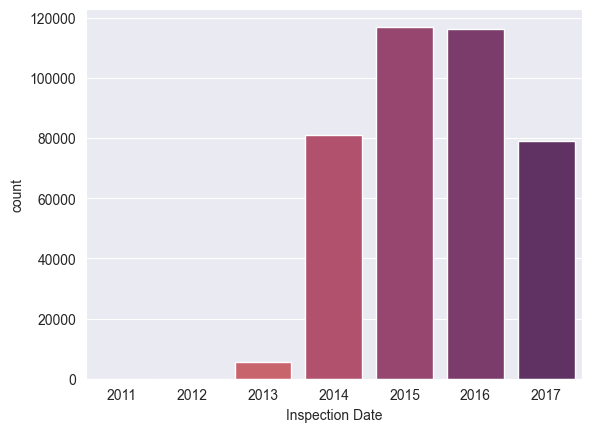

In [21]:
sns.barplot(inspection_by_year, palette = 'flare')

In [22]:
# clearing the data from rows before 2017
for column in ["Inspection Grade", "Inspection Critical"]:
    inspection_data[column] = inspection_data.apply(lambda row: None if row["Inspection Date"].year < 2017 else row[column], axis = 1)  

In [23]:
# keeping relevant column and removing duplicates 
inspection_data = inspection_data[["Name", "Address", "ZipCode","Cuisine", "Inspection Date", "Inspection Grade", "Inspection Critical"]]
inspection_data.sort_values("Inspection Date", ascending=False, inplace=True)
inspection_data.drop_duplicates(["Name", "Address"], inplace=True)
inspection_data

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_33295/313006549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inspection_data.sort_values("Inspection Date", ascending=False, inplace=True)
/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_33295/313006549.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inspection_data.drop_duplicates(["Name", "Address"], inplace=True)


,Name,Address,ZipCode,Cuisine,Inspection Date,Inspection Grade,Inspection Critical
123495,Steves Pizza,"603 Sutter Ave, Brooklyn, 11207",11207,[Pizza],2017-08-26,A,True
100161,Mike'S Pub,"7919 Jamaica Avenue, Queens, 11421",11421,[American],2017-08-26,NaN,True
270194,China Panda,"351 New Lots Ave, Brooklyn, 11207",11207,[Chinese],2017-08-26,A,False
384190,Wo Hop Chinese Restaurant,"3150 Fulton Street, Brooklyn, 11208",11208,[Chinese],2017-08-26,A,True
389032,Nelly'S Cakes & Party Supplies,"597 New Lots Ave, Brooklyn, 11207",11207,[Bakery],2017-08-26,A,True
...,...,...,...,...,...,...,...
251667,NaN,"2614 Jackson Ave, Queens, 11101",11101,[Other],1900-01-01,None,None
313892,Elio'S Fine Foods,"20 Maiden Ln, New York, 10038",10038,[Other],1900-01-01,None,None
212425,Swiming Pool,"1815 215Th St, Queens, 11360",11360,[Other],1900-01-01,None,None
313962,Levante,"2621 Jackson Ave, Queens, 11101",11101,[Other],1900-01-01,None,None


### TripAdvisor Restaurant Data
this dataset includes: restaurant name, cuisine, a popular menu item. 

**goal:** keep relevant columns, maintain formatting.


In [24]:
ta_data

,Title,Number of review,Catagory,Reveiw Comment,Popular food,Online Order
0,All Stars Sports Bar & Grill,21,"Bar, Pub","“The fries were terrific also, hot crisp...”",fries,Yes
1,Olio e Piu,"2,998","Italian, Pizza",“I love the food and our server Maria!”,filet mignon,Yes
2,Boucherie West Village,"1,465","French, Steakhouse",“The filet mignon was impeccable and the musse...,lobster,Yes
3,Club A Steakhouse,"4,413","American, Steakhouse",“My seafood cocktail had wonderful large lump ...,cacio e pepe,Yes
4,Piccola Cucina Estiatorio,403,"Italian, Sicilian",“penne al pomodoro and bucatini cacio e pepe w...,mussels,Yes
...,...,...,...,...,...,...
10392,The Sandwich Slut,No,"Mediterranean, Turkish",No,No,No
10393,The Sandwich Slut,No,"Mediterranean, Turkish",No,No,No
10394,The Sandwich Post,No,"Mediterranean, Turkish",No,No,No
10395,The Sandwich Cafe,No,"Mediterranean, Turkish",No,No,No


In [25]:
# assessing duplicate rows 
ta_data.duplicated(["Title"]).value_counts()

False    7237
True     3160
Name: count, dtype: int64

In [26]:
# since the only indication for a restaurant is the title, we will simply drop duplicates after collecting the popular foods in the restaurants. Since the goal is to use the items as a reference to what the restaurant is selling, this should be okay - the dimesion of item popularity is irrelevant. 
ta_data["Items"] = ta_data["Title"].apply(lambda s: list(set(list(ta_data[ta_data["Title"] == s]["Popular food"])))).apply(lambda l: [x for x in l if x != "No" and x != "Yes"])
ta_data.drop_duplicates(["Title"], inplace=True)
ta_data.drop(["Popular food"], axis=1, inplace=True)

In [27]:
# changing column names, changing "cuisine" column into a list
ta_data = ta_data[["Title", "Catagory", "Reveiw Comment", "Items"]]
ta_data.columns = ["Name", "Cuisine", "Review Comment", "Items"]
ta_data["Cuisine"] = ta_data["Cuisine"].str.split(", ")

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_33295/128074211.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ta_data["Cuisine"] = ta_data["Cuisine"].str.split(", ")


In [28]:
ta_data

,Name,Cuisine,Review Comment,Items
0,All Stars Sports Bar & Grill,"[Bar, Pub]","“The fries were terrific also, hot crisp...”","[fries, Pub, Dumplings, Pizza, salmon]"
1,Olio e Piu,"[Italian, Pizza]",“I love the food and our server Maria!”,[filet mignon]
2,Boucherie West Village,"[French, Steakhouse]",“The filet mignon was impeccable and the musse...,[lobster]
3,Club A Steakhouse,"[American, Steakhouse]",“My seafood cocktail had wonderful large lump ...,[cacio e pepe]
4,Piccola Cucina Estiatorio,"[Italian, Sicilian]",“penne al pomodoro and bucatini cacio e pepe w...,[mussels]
...,...,...,...,...
10389,The Shawarma Snob,"[Mediterranean, Turkish]",No,[]
10391,The Shannon Pot,"[Mediterranean, Turkish]",No,[]
10392,The Sandwich Slut,"[Mediterranean, Turkish]",No,[]
10394,The Sandwich Post,"[Mediterranean, Turkish]",No,[]


### Combining the Data
this section will focus on combining the 4 previous tables. 

In [29]:
def consolidate_columns(df, columns_set_name, concat=False):
    # consolidates the contents of two columns in one of two ways: either concatenating the information to create a bigger list (e.g, for cuisine styles or item lists), or by filling nulls from the second column into the first column. the changes are done in place, so no return is needed. 
    x_column = columns_set_name + "_x"
    y_column = columns_set_name + "_y"
    if concat:
        df[x_column] = df.apply(lambda row: row[x_column] + row[y_column] if isinstance(row[x_column], list) and isinstance(row[y_column], list) else row[x_column], axis = 1)
    df[x_column].fillna(df[y_column], inplace=True)
    df[columns_set_name] = df[x_column]
    df.drop([x_column, y_column], axis=1, inplace=True)

In [30]:
# join - Google Maps + Menu Items; outer join is used since both these datasets contain crucial information: location, rating+price/items lists+cuisine.
gm_and_menu = pd.merge(menu_rest_data, gm_data, on=["ZipCode", "Name"], how="outer")
gm_and_menu

,Name,Cuisine,Address_x,ZipCode,Items,Rating,Price Category,Address_y
0,Cho Dang Gol,[Korean],"55 W 35th St, New York, 10001",10001,[Homemade Dumpling Ddukgook & Bossam ????? ???...,NaN,NaN,NaN
1,Grace Street Coffee & Desserts,"[Coffee & Tea, Korean]","17 W 32nd St, New York, 10001",10001,"[Original Basque Burnt Cheesecake (4 Inch), Ch...",NaN,NaN,NaN
2,Han Bat Korean Restaurant,[Korean],"53 W 35th St, New York, 10001",10001,"[Han Bat Combo íë°­ì½¤ë³´, 38 y. Gobdol Bi B...",NaN,NaN,NaN
3,Hyo Dong Gak,"[Chinese, Korean]","51 W 35th St, New York, 10001",10001,"[A1. Fried pork Dumplings, A2. Steamed Dumplin...",NaN,NaN,NaN
4,Koloman,NaN,NaN,10001,NaN,4.4,1.0,"16 W 29th St, New York, 10001"
...,...,...,...,...,...,...,...,...
790,Pattanian Thai Restaurant,NaN,NaN,11385,NaN,4.7,2.0,"64-02 Fresh Pond Rd, Queens, 11385"
791,The Avenue Restaurant & Bar,NaN,NaN,11385,NaN,4.3,1.0,"71-22 Myrtle Ave, Queens, 11385"
792,Libertad Restaurant,NaN,NaN,11417,NaN,4.1,1.0,"96-19 Liberty Ave, Queens, 11417"
793,Nuria's Restaurant,NaN,NaN,11435,NaN,4.1,1.0,"13816 Jamaica Ave, Queens, 11435"


In [31]:
# join - Google Maps, Menu Items + Trip Advisor. Outer Join is used; the Trip Advisor data offers no addresses, so it is less appropriate for differentiating locations, but maybe the inspection dataset can offer this data later. The key is just the name. This dataset adds item lists and cuisine styles, as well as a list of popular items. 
gm_ta_menu_data = pd.merge(gm_and_menu, ta_data, on=["Name"], how="outer")
gm_ta_menu_data["Popular Foods"] = gm_ta_menu_data["Items_y"]
gm_ta_menu_data

,Name,Cuisine_x,Address_x,ZipCode,Items_x,Rating,Price Category,Address_y,Cuisine_y,Review Comment,Items_y,Popular Foods
0,#1 Deli Gourmet,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Japanese, Sushi]",No,[],[]
1,#VALUE!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Seafood, Soups]",No,[],[]
2,&Pizza,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[French, American]",“&pizza has REOPENED on Wall St!”,[],[]
3,&pizza - Astor Place,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Japanese, Sushi]",“Awesome pizza custom made to order. I...”,[],[]
4,&pizza - NoMad,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Pizza, Fast Food]",“Solid pizza”,[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...
7779,westbourne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Indian, Asian]",“YUM”,[],[]
7780,yeras Restaurant and sports bar,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Wine Bar, Mediterranean]",No,[],[]
7781,არგო,NaN,NaN,11223,NaN,4.6,2.0,"1985 Coney Island Ave, Brooklyn, 11223",NaN,NaN,NaN,NaN
7782,უბანი,NaN,NaN,11209,NaN,4.7,2.0,"Georgian Cuisine, 8309 3rd Ave, 11209",NaN,NaN,NaN,NaN


In [32]:
consolidate_columns(gm_ta_menu_data, "Items", concat=True)
consolidate_columns(gm_ta_menu_data, "Cuisine", concat=True)
consolidate_columns(gm_ta_menu_data, "Address")
gm_ta_menu_data

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_33295/1464467434.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[x_column].fillna(df[y_column], inplace=True)
/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_33295/1464467434.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alway

,Name,ZipCode,Rating,Price Category,Review Comment,Popular Foods,Items,Cuisine,Address
0,#1 Deli Gourmet,NaN,NaN,NaN,No,[],[],"[Japanese, Sushi]",NaN
1,#VALUE!,NaN,NaN,NaN,No,[],[],"[Seafood, Soups]",NaN
2,&Pizza,NaN,NaN,NaN,“&pizza has REOPENED on Wall St!”,[],[],"[French, American]",NaN
3,&pizza - Astor Place,NaN,NaN,NaN,“Awesome pizza custom made to order. I...”,[],[],"[Japanese, Sushi]",NaN
4,&pizza - NoMad,NaN,NaN,NaN,“Solid pizza”,[],[],"[Pizza, Fast Food]",NaN
...,...,...,...,...,...,...,...,...,...
7779,westbourne,NaN,NaN,NaN,“YUM”,[],[],"[Indian, Asian]",NaN
7780,yeras Restaurant and sports bar,NaN,NaN,NaN,No,[],[],"[Wine Bar, Mediterranean]",NaN
7781,არგო,11223,4.6,2.0,NaN,NaN,NaN,NaN,"1985 Coney Island Ave, Brooklyn, 11223"
7782,უბანი,11209,4.7,2.0,NaN,NaN,NaN,NaN,"Georgian Cuisine, 8309 3rd Ave, 11209"


In [33]:
# final join - Google Maps, Trip Advisor, Menu Items + Inspection Data. Left join is used; there is no use for information about restaurants with not a single data point about item lists/ratings/zip code. This dataset only adds inspection date and results (grade + critical flag).  
full_combo = pd.merge(gm_ta_menu_data, inspection_data, on=["ZipCode", "Name"], how="left")
consolidate_columns(full_combo, "Cuisine", concat=True)
consolidate_columns(full_combo, "Address")
full_combo

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_33295/1464467434.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[x_column].fillna(df[y_column], inplace=True)
/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_33295/1464467434.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alway

,Name,ZipCode,Rating,Price Category,Review Comment,Popular Foods,Items,Inspection Date,Inspection Grade,Inspection Critical,Cuisine,Address
0,#1 Deli Gourmet,NaN,NaN,NaN,No,[],[],NaT,NaN,NaN,"[Japanese, Sushi]",NaN
1,#VALUE!,NaN,NaN,NaN,No,[],[],NaT,NaN,NaN,"[Seafood, Soups]",NaN
2,&Pizza,NaN,NaN,NaN,“&pizza has REOPENED on Wall St!”,[],[],NaT,NaN,NaN,"[French, American]",NaN
3,&pizza - Astor Place,NaN,NaN,NaN,“Awesome pizza custom made to order. I...”,[],[],NaT,NaN,NaN,"[Japanese, Sushi]",NaN
4,&pizza - NoMad,NaN,NaN,NaN,“Solid pizza”,[],[],NaT,NaN,NaN,"[Pizza, Fast Food]",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7788,westbourne,NaN,NaN,NaN,“YUM”,[],[],NaT,NaN,NaN,"[Indian, Asian]",NaN
7789,yeras Restaurant and sports bar,NaN,NaN,NaN,No,[],[],NaT,NaN,NaN,"[Wine Bar, Mediterranean]",NaN
7790,არგო,11223,4.6,2.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,"1985 Coney Island Ave, Brooklyn, 11223"
7791,უბანი,11209,4.7,2.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,"Georgian Cuisine, 8309 3rd Ave, 11209"


In [34]:
len(str(full_combo["Items"][7009])) < 4

False

In [35]:
# at this point, all restaurants that have less than one relevant datapoint should be removed. 
full_combo["keep"] = full_combo.apply(lambda row: not (
                                          len(str(row["ZipCode"])) != 5
                                      or
                                          (
                                      len(str(["Items"])) < 5
                                      and not str(["Rating"])[0].isdigit() 
                                          )
)
                                      , 
                                      axis = 1)
full_combo["keep"].value_counts()

keep
False    6989
True      804
Name: count, dtype: int64

In [36]:
full_combo = full_combo[full_combo["keep"]]
full_combo.drop(["keep"], axis = 1, inplace=True)
full_combo.reset_index(drop=True, inplace=True)
full_combo

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_33295/386943631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_combo.drop(["keep"], axis = 1, inplace=True)


,Name,ZipCode,Rating,Price Category,Review Comment,Popular Foods,Items,Inspection Date,Inspection Grade,Inspection Critical,Cuisine,Address
0,218,10013,4.2,1.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,"218 Grand St, New York, 10013"
1,251 Ginza Sushi,10016,NaN,NaN,NaN,NaN,"[Soda, Spring Water and soda, Snapple Ice Tea,...",NaT,NaN,NaN,"[Japanese, Sushi]","251 E 35th St, New York, 10016"
2,3 Guys Restaurant,10021,NaN,NaN,“Quick lunch and good service”,[],"[Cold Cereal, Cold Cereal with Banana, Hot Oat...",NaT,NaN,NaN,"[American, Diner, Cafe, Japanese]","960 Madison Ave, New York, 10021"
3,4 Caminos Mexican Restaurant,11385,4.1,2.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,"67-22 Fresh Pond Rd, Queens, 11385"
4,5 Brothers Gourmet Deli,10036,NaN,NaN,NaN,NaN,"[fresh homemade beef brisket sandwich, Fresh T...",NaT,NaN,NaN,"[American, Burgers, Deli Food, Sandwiches]","689 10th Ave, New York, 10036"
...,...,...,...,...,...,...,...,...,...,...,...,...
799,ilili Restaurant,10001,4.5,3.0,NaN,NaN,"[Lunch Prix Fixe Special, Falafel Wrap, Grille...",NaT,NaN,NaN,"[Mediterranean, Middle Eastern, Tapas]","236 5th Ave, New York, 10001"
800,taïm mediterranean kitchen,10038,4.3,1.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,"75 Maiden Ln, New York, 10038"
801,არგო,11223,4.6,2.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,"1985 Coney Island Ave, Brooklyn, 11223"
802,უბანი,11209,4.7,2.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,"Georgian Cuisine, 8309 3rd Ave, 11209"


#### setting list columns
this will be useful in various contexts - when processing is similar for these lists of strings 

In [37]:
list_columns = ["Cuisine", "Popular Foods", "Items"]

#### basic cleaning - items, popular items, cuisines

In [38]:
def clean_items_in_list(l):
    # ensures menu item lists are ready for processing: removes stop words, punctuation, digits etc. 
    if isinstance(l, list):
        clean_l = []
        for item in l:
            if isinstance(item, str):
                clean_item = "".join([c.lower() for c in item if c.isascii() or c == " "])
                clean_item = "".join([c for c in clean_item if not c.isdigit()])
                clean_item = " ".join([c.split(".")[-1] for c in clean_item.split()])
                clean_item = clean_item.replace("-", ", ").replace("&", ", ").strip()
                clean_item = "".join([c.lower() for c in clean_item if c not in string.punctuation])
                clean_item = " ".join([c.strip() for c in clean_item.split()])
                if clean_item != "" and clean_item != " ":
                    clean_l.append(clean_item)
        return clean_l
    else:
        return l

In [39]:
for column in list_columns:
    full_combo[column] = full_combo[column].apply(clean_items_in_list)

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_33295/3827518194.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_combo[column] = full_combo[column].apply(clean_items_in_list)


In [40]:
cuisines = []
for line in full_combo["Cuisine"]:
    print(line)
    if isinstance(line, list):
        for cuisine in line:
            if cuisine not in cuisines:
                cuisines.append(cuisine.lower())
cuisines 

nan
['japanese', 'sushi']
['american', 'diner', 'cafe', 'japanese']
nan
['american', 'burgers', 'deli food', 'sandwiches']
['bakery pastries', 'sandwiches', 'smoothies juices']
['american', 'burgers', 'sushi', 'american', 'contemporary']
nan
['latin american', 'puerto rican', 'chinese', 'asian']
['pizza', 'pizza', 'fast food', 'pizza']
['chinese', 'chinese', 'asian', 'chinese']
['cafcoffeetea']
nan
nan
nan
['japanese', 'sushi', 'japanese', 'asian', 'japanese']
['latin american', 'puerto rican', 'latin cuban dominican puerto rican south central american']
['indian']
['japanese', 'sushi', 'japanese']
['japanese', 'noodles', 'sushi', 'japanese', 'asian', 'japanese']
['spanish', 'tapas', 'spanish', 'mediterranean', 'spanish']
nan
['sandwiches', 'soups', 'teahouses']
['sandwiches', 'teahouses']
['american new', 'french', 'localorganic', 'american', 'french']
['american new', 'latin cuban dominican puerto rican south central american']
nan
['asian', 'healthy', 'japanese', 'lunch specials', '

['japanese',
 'sushi',
 'american',
 'diner',
 'cafe',
 'burgers',
 'deli food',
 'sandwiches',
 'bakery pastries',
 'smoothies juices',
 'contemporary',
 'latin american',
 'puerto rican',
 'chinese',
 'asian',
 'pizza',
 'fast food',
 'cafcoffeetea',
 'latin cuban dominican puerto rican south central american',
 'indian',
 'noodles',
 'spanish',
 'tapas',
 'mediterranean',
 'soups',
 'teahouses',
 'american new',
 'french',
 'localorganic',
 'healthy',
 'lunch specials',
 'thai',
 'salads',
 'seafood',
 'greek',
 'soul food',
 'mexican',
 'southwestern',
 'italian',
 'wine bar',
 'chicken',
 'pasta',
 'wings',
 'other',
 'ethiopian',
 'dominican',
 'steak',
 'bagels',
 'bagelspretzels',
 'kosher',
 'middle eastern',
 'vegetarian',
 'lebanese',
 'cocktails',
 'moroccan',
 'bar',
 'hot dogs',
 'bistro',
 'european',
 'irish',
 'bar food',
 'steakhouse',
 'korean',
 'barbecue',
 'turkish',
 'alcohol',
 'brazilian',
 'south american',
 'pub',
 'gastropub',
 'argentinean',
 'latin',
 'tib

#### standardizing nulls

In [41]:
full_combo["Inspection Grade"] = full_combo["Inspection Grade"].fillna('Not Yet Graded')
full_combo["Inspection Grade"] = full_combo["Inspection Grade"].replace('Not Yet Graded', None)
full_combo["Cuisine"] = full_combo["Cuisine"].apply(lambda x: list(set(x)) if isinstance(x, list) else x)
for column in list_columns:
    full_combo[column] = full_combo[column].apply(lambda l: l if isinstance(l, list) and l!= [] else None)

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_33295/1033572542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_combo["Inspection Grade"] = full_combo["Inspection Grade"].fillna('Not Yet Graded')
/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_33295/1033572542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_combo["Inspection Grade"] = full_combo["Inspection Grade"].replace('Not Yet Graded', None)
/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_33295/103357

#### create a marking of inspection info existing

In [42]:
full_combo["grade and rating"] = full_combo.apply(lambda row: (row["Inspection Grade"] != None or (row["Inspection Critical"] is True or  row["Inspection Critical"] is False))and row["Rating"] != None, axis = 1)
full_combo["grade and rating"].value_counts()

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_33295/1999400664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_combo["grade and rating"] = full_combo.apply(lambda row: (row["Inspection Grade"] != None or (row["Inspection Critical"] is True or  row["Inspection Critical"] is False))and row["Rating"] != None, axis = 1)


grade and rating
False    610
True     194
Name: count, dtype: int64

### Basic EDA on the Working Data Set

In [43]:
eda_summary = {}
for column in full_combo.columns:
    non_null_count = full_combo[column].notnull().sum()
    total_entries = len(full_combo[column])
    proportion_not_null = str(round(non_null_count/total_entries, 2) * 100) + "%"
    eda_summary[column] = [non_null_count, proportion_not_null]
pd.DataFrame.from_dict(eda_summary, orient='index', columns = ["Non-Null Count", "Non-Null Proportion"])

,Non-Null Count,Non-Null Proportion
Name,804,100.0%
ZipCode,804,100.0%
Rating,306,38.0%
Price Category,306,38.0%
Review Comment,266,33.0%
Popular Foods,117,15.0%
Items,527,66.0%
Inspection Date,253,31.0%
Inspection Grade,149,19.0%
Inspection Critical,194,24.0%


#### exploring further data enrichemnt needs

In [44]:
## checking if there is a case where a restaurant has no cuisine, but has some items. 
full_combo["items with no cuisine"] = full_combo.apply(lambda row: row["Cuisine"] == None and row["Items"] != None, axis = 1)
full_combo["items with no cuisine"].value_counts()

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_33295/3262703145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_combo["items with no cuisine"] = full_combo.apply(lambda row: row["Cuisine"] == None and row["Items"] != None, axis = 1)


items with no cuisine
False    802
True       2
Name: count, dtype: int64

In [45]:
## checking the opposite - are there cases where there are items but no cuisine 
full_combo["cuisine with no items"] = full_combo.apply(lambda row: row["Cuisine"] != None and row["Items"] == None, axis = 1)
full_combo["cuisine with no items"].value_counts()

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_33295/3390405387.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_combo["cuisine with no items"] = full_combo.apply(lambda row: row["Cuisine"] != None and row["Items"] == None, axis = 1)


cuisine with no items
False    731
True      73
Name: count, dtype: int64

#### preparing file for export

In [46]:
revert_to_string = lambda l: ", ".join([i for i in l if isinstance(i, str)]) if isinstance(l, list) else ""
for column in list_columns:
    full_combo[column] = full_combo[column].apply(revert_to_string)

/var/folders/68/kjwj3q012r99v59302lxlcbc0000gn/T/ipykernel_33295/1081902078.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_combo[column] = full_combo[column].apply(revert_to_string)


In [47]:
pd.DataFrame.to_csv(full_combo, "full_combo.csv", index=False)

### training models

In [48]:
full_combo

,Name,ZipCode,Rating,Price Category,Review Comment,Popular Foods,Items,Inspection Date,Inspection Grade,Inspection Critical,Cuisine,Address,grade and rating,items with no cuisine,cuisine with no items
0,218,10013,4.2,1.0,NaN,,,NaT,None,NaN,,"218 Grand St, New York, 10013",False,False,False
1,251 Ginza Sushi,10016,NaN,NaN,NaN,,"soda, spring water and soda, snapple ice tea, ...",NaT,None,NaN,"sushi, japanese","251 E 35th St, New York, 10016",False,False,False
2,3 Guys Restaurant,10021,NaN,NaN,“Quick lunch and good service”,,"cold cereal, cold cereal with banana, hot oatm...",NaT,None,NaN,"japanese, american, cafe, diner","960 Madison Ave, New York, 10021",False,False,False
3,4 Caminos Mexican Restaurant,11385,4.1,2.0,NaN,,,NaT,None,NaN,,"67-22 Fresh Pond Rd, Queens, 11385",False,False,False
4,5 Brothers Gourmet Deli,10036,NaN,NaN,NaN,,"fresh homemade beef brisket sandwich, fresh to...",NaT,None,NaN,"sandwiches, deli food, american, burgers","689 10th Ave, New York, 10036",False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,ilili Restaurant,10001,4.5,3.0,NaN,,"lunch prix fixe special, falafel wrap, grilled...",NaT,None,NaN,"middle eastern, tapas, mediterranean","236 5th Ave, New York, 10001",False,False,False
800,taïm mediterranean kitchen,10038,4.3,1.0,NaN,,,NaT,None,NaN,,"75 Maiden Ln, New York, 10038",False,False,False
801,არგო,11223,4.6,2.0,NaN,,,NaT,None,NaN,,"1985 Coney Island Ave, Brooklyn, 11223",False,False,False
802,უბანი,11209,4.7,2.0,NaN,,,NaT,None,NaN,,"Georgian Cuisine, 8309 3rd Ave, 11209",False,False,False


In [49]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, menu_rest_data["Cuisine - Least Frequent"], test_size=0.25, random_state=42)

NameError: name 'tfidf_matrix' is not defined

In [ ]:
model = RandomForestClassifier()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_true, y_pred)
# precision = precision_score(y_true, y_pred, average='weighted')  
# recall = recall_score(y_true, y_pred, average='weighted')
# f1 = f1_score(y_true, y_pred, average='weighted')

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
"https://www.nytimes.com/interactive/2017/12/12/dining/best-restaurant-nyc-pete-wells.html"